---
# Food Vision Fine tuning Project
---

## В този проект ще се разгледа следното:

- Fine-tuning като тип трансферно обучение за модификация на предварително обучен модел за по-добро адаптиране към данни.
- Използване на Keras Functional API за построяване на модели в TensorFlow.
- Експериментиране с по-малък набор от данни (например 1-10% от обучителните примери за 10 класа храни) за по-бързи итерации.
- Техники за увеличаване на данните (data augmentation), за да увеличите разнообразието на обучаващия набор без да добавяте повече данни.
  
### Изпълнение на серия моделни експерименти върху данните ни от Food Vision:

- Модел 0: Трансферно обучение с използване на Keras Functional API.
- Модел 1: Модел за извличане на признаци чрез трансферно обучение върху 1% от данните с аугментация на данните.
- Модел 2: Модел за извличане на признаци чрез трансферно обучение върху 10% от данните с аугментация на данните.
- Модел 3: Fine-tuned модел чрез трансферно обучение върху 10% от данните.
- Модел 4: Fine-tuned модел чрез трансферно обучение върху 100% от данните.
- Въведение на колбека ModelCheckpoint за запазване на промеждинни резултати от обучението.

In [1]:
from helper_functions import *

In [2]:
!nvidia-smi

Tue Jul 16 22:20:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.70                 Driver Version: 560.70         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0             27W /   90W |       0MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

### Create training and test directories

In [4]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/train/"

### Creating data inputs

In [5]:
import tensorflow as tf

In [6]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

In [7]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size = IMG_SHAPE,
                                                                            label_mode ="categorical",
                                                                            batch_size = BATCH_SIZE)
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SHAPE,
                                                                           label_mode = "categorical",
                                                                           batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


In [8]:
# Check the training data type 
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

**В посочения изход:**

- **(None, 224, 224, 3)** отнася се до формата на тензора на нашите изображения, където **None** е размерът на партидата, **224** е височината (и широчината), а **3** са цветовите канали (червен, зелен, син).
- **(None, 10)** отнася се до формата на тензора на етикетите, където **None** е размерът на партидата, а **10** е броят на възможните етикети (10 различни класа на храни).
- И тензорите на изображенията, и етикетите са от тип **tf.float32**.
- **None** за **batch_size** е така, защото се използва само по време на обучението на модела. Можете да си мислите за None като запълнител, който чака да бъде попълнен с параметъра **batch_size** от **image_dataset_from_directory()**.
- Още едно предимство при използването на **tf.data.Dataset API** са свързаните с него методи.

In [9]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[1.63887756e+02 1.65887756e+02 1.44887756e+02]
   [1.80382660e+02 1.79382660e+02 1.59382660e+02]
   [1.59581635e+02 1.62795914e+02 1.45663269e+02]
   ...
   [1.38356964e+02 1.42928436e+02 1.37275421e+02]
   [1.23331627e+02 1.29545959e+02 1.27474510e+02]
   [1.20596802e+02 1.30183563e+02 1.29183563e+02]]

  [[1.69051025e+02 1.68051025e+02 1.50051025e+02]
   [1.82280624e+02 1.81280624e+02 1.61280624e+02]
   [1.65816330e+02 1.69030609e+02 1.52658173e+02]
   ...
   [1.39300888e+02 1.41285599e+02 1.35999908e+02]
   [1.17556183e+02 1.21847031e+02 1.20704155e+02]
   [1.18361900e+02 1.25571182e+02 1.25168091e+02]]

  [[1.63005112e+02 1.61576538e+02 1.43790817e+02]
   [1.78515305e+02 1.77484695e+02 1.59500000e+02]
   [1.58908157e+02 1.61122452e+02 1.47765305e+02]
   ...
   [1.40887711e+02 1.41459183e+02 1.36459183e+02]
   [1.27321396e+02 1.29479584e+02 1.26576546e+02]
   [1.23515221e+02 1.28076508e+02 1.28367294e+02]]

  ...

  [[8.90663528e+01 4.30663567e+01 1.90663567e+01]
   [8

# Model 0: Building a transfer learning model using the Keras Functional API

In [12]:
import tensorflow as tf

In [14]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model 
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_models
x = base_model(inputs)
print(f"Shape after base_model:{x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling")(x)
print(f"After Global Average Pooling 2D: {x.shape}")

# 7. Create the output activation layers
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine inputs with the outputs layer
model_0 = tf.keras.Model(inputs,outputs)

Shape after base_model:(None, 7, 7, 1280)
After Global Average Pooling 2D: (None, 1280)


## Compile the model

In [15]:
model_0.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

## Fit the model

In [16]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data_10_percent,
                                 validation_steps= int(0.25*len(test_data_10_percent)),
                                 callbacks=[create_tensorboard_callback("transfer_learning","10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240716-224208
Epoch 1/5
24/24 [==============================] - 15s 150ms/step - loss: 1.9528 - accuracy: 0.3773 - val_loss: 1.3668 - val_accuracy: 0.7448
Epoch 2/5
24/24 [==============================] - 2s 78ms/step - loss: 1.1853 - accuracy: 0.7307 - val_loss: 0.9461 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 2s 78ms/step - loss: 0.8542 - accuracy: 0.8107 - val_loss: 0.6835 - val_accuracy: 0.8750
Epoch 4/5
24/24 [==============================] - 2s 77ms/step - loss: 0.6995 - accuracy: 0.8360 - val_loss: 0.5558 - val_accuracy: 0.8646
Epoch 5/5
24/24 [==============================] - 2s 81ms/step - loss: 0.5876 - accuracy: 0.8573 - val_loss: 0.5586 - val_accuracy: 0.8698


### Check layers in base model

In [18]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x0000029D42CF2D10>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x0000029D42D093F0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x0000029D4265CCD0>
3 <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029D42D09ED0>
4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029D42CA3610>
5 <keras.layers.core.activation.Activation object at 0x0000029D423DD0F0>
6 <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029D426BD4B0>
7 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029D426BE4A0>
8 <keras.layers.core.activation.Activation object at 0x0000029D4265EB90>
9 <keras.layers.convolutional.conv2d.Conv2D object at 0x0000029D426BD1B0>
10 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029D426BE2F0>
11 <keras.layers.core.activation.Activation object at 0x0000029D426BD780>
12 <keras.lay

In [19]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   0          ['rescaling_1[0][0]']            
 )                              3)                                                

Всеки от слоевете в модела има определен брой параметри. Тъй като използваме предварително обучен модел, можете да си мислите за тези параметри като шаблони, които базовият модел е научил от друг набор от данни. Поради факта, че задаваме `base_model.trainable = False`, тези шаблони остават непроменени по време на обучението – те са замразени и не се актуализират.

In [21]:
# Model_0 summary
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


- Целият ни модел има 5 слоя, но един от тези слоеве (efficientnetv2-b0) има 269 слоя.

- Можете да видите как формата на изхода започна като `(None, 224, 224, 3)` за входния слой (формата на нашите изображения), но беше трансформирана до (None, 10) от изходния слой (формата на нашите етикети), където `None` е placeholder за batch size.

- Единствените обучаеми параметри в модела са тези в изходния слой.

## Check training curves

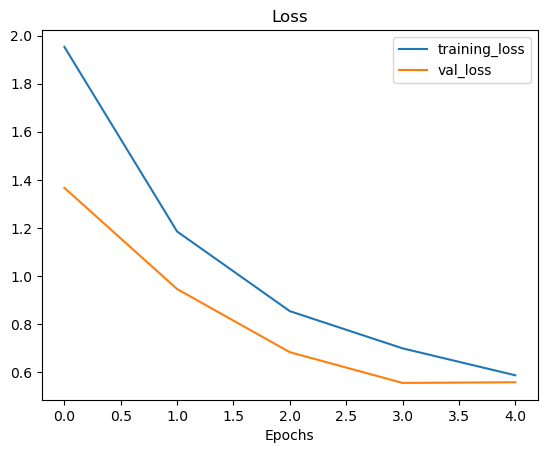

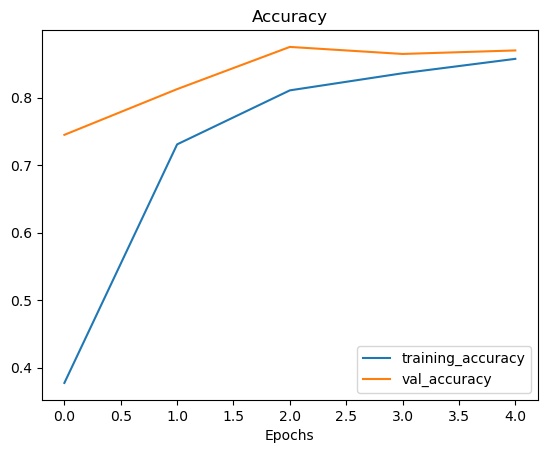

In [22]:
plot_loss_curves(history_10_percent)

# Running a series of transfer learning experiments

- **Model 1**: Use feature extraction transfer learning on 1% of the training data with **data augmentation**.
- **Model 2**: Use feature extraction transfer learning on 10% of the training data with **data augmentation** and save the results to a **checkpoint**.
- **Model 3**: Fine-tune the Model 2 checkpoint on 10% of the training data with **data augmentation**.
- **Model 4**: Fine-tune the Model 2 checkpoint on 100% of the training data with **data augmentation**.

## Model 1 (1% of the training data with data augmentation)

### Create training and test directories

In [25]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

In [26]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

### Creating data inputs

In [29]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         image_size = IMG_SHAPE,
                                                                         batch_size = BATCH_SIZE,
                                                                         label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SHAPE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

Found 70 files belonging to 10 classes.
Found 750 files belonging to 10 classes.


## Adding data augmentation right into the model

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

# NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

## View random image

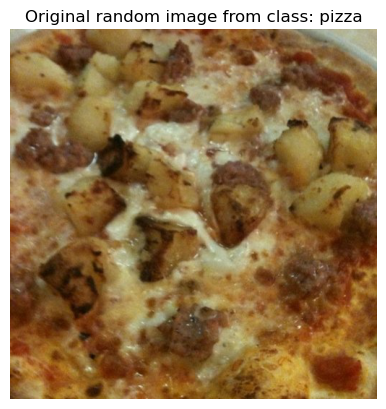

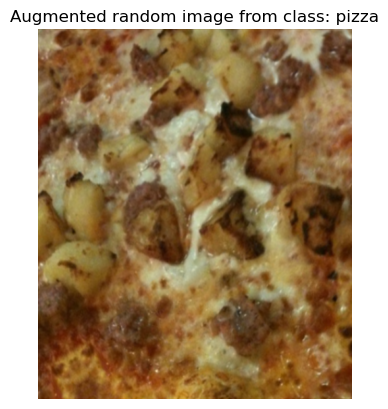

In [57]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

tf.get_logger().setLevel('ERROR')

target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## 1. Creating model_1

In [72]:
# Setup and intput shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create layers
inputs = layers.Input(shape = input_shape, name = "input_layer")

# Add in data augmentation sequential as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x,training = False)

# Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Create a model with inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

## 2. Compile model_1

In [73]:
model_1.compile(loss ="categorical_crossentropy",
                optimizer = "Adam",
                metrics = ["accuracy"])

## 3. Fit the model

In [74]:
history_1 = model_1.fit(train_data_1_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_1_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25*len(test_data)),
                        callbacks = [create_tensorboard_callback("transfer_learning",
                                                                 "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240716-233206
Epoch 1/5
3/3 [==============================] - 10s 994ms/step - loss: 2.2858 - accuracy: 0.1857 - val_loss: 2.2168 - val_accuracy: 0.1875
Epoch 2/5
3/3 [==============================] - 1s 365ms/step - loss: 2.0985 - accuracy: 0.3286 - val_loss: 2.1011 - val_accuracy: 0.2917
Epoch 3/5
3/3 [==============================] - 1s 368ms/step - loss: 1.8637 - accuracy: 0.5000 - val_loss: 2.0354 - val_accuracy: 0.2969
Epoch 4/5
3/3 [==============================] - 1s 365ms/step - loss: 1.7184 - accuracy: 0.6286 - val_loss: 1.9207 - val_accuracy: 0.4010
Epoch 5/5
3/3 [==============================] - 1s 364ms/step - loss: 1.6536 - accuracy: 0.6143 - val_loss: 1.8662 - val_accuracy: 0.4375


In [75]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

# Evaluate on the full test data

In [76]:
# Evaluate on the test data
result_1_percent_data = model_1.evaluate(test_data)
result_1_percent_data

24/24 [==============================] - 2s 52ms/step - loss: 1.8786 - accuracy: 0.4293


[1.8785940408706665, 0.42933332920074463]

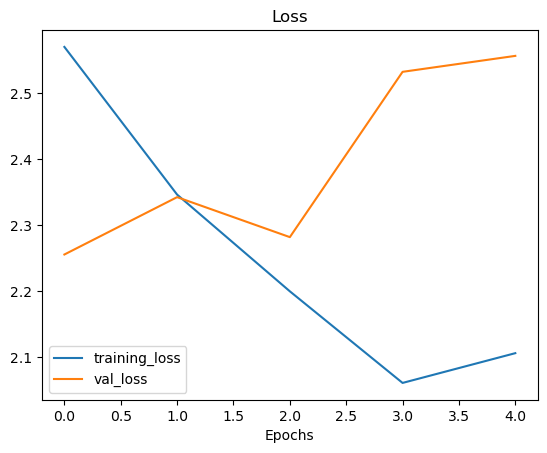

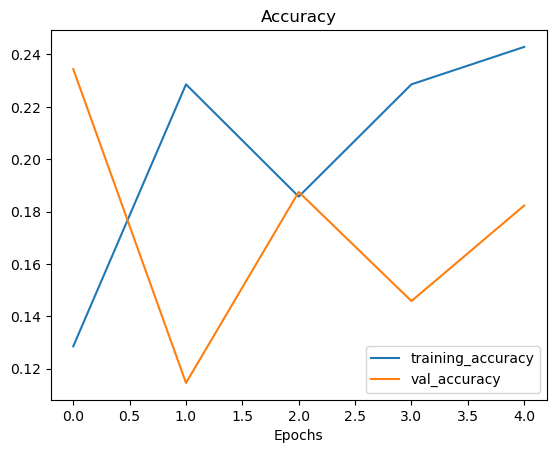

In [77]:
plot_loss_curves(history_1_percent)

# Model 2 (10% of data with data augmentation)

In [78]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

## Set up the data

In [79]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size = IMG_SHAPE,
                                                                            label_mode = "categorical")
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                           image_size = IMG_SHAPE,
                                                                           label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## 1. Creating the model

In [80]:
# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Creating inputs layers
inputs = layers.Input(shape = input_shape, name = "input layer")
x = data_augmentation(inputs)
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layers")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = keras.Model(inputs,outputs)

## 2. Compile the model

In [87]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = "Adam",
                metrics=["accuracy"])

## Creating checkpoint callbacks

In [88]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     save_best_only=True,
                                                     save_freq="epoch",
                                                     verbose=1)

## 3. Fit the model

In [89]:
history_10_percent_data = model_2.fit(train_data_10_percent,
                                      epochs = 5,
                                      validation_data= test_data,
                                      validation_steps=int(0.25*len(test_data)),
                                      callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240716-234955
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0398 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 1.48920, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 15s 326ms/step - loss: 2.0398 - accuracy: 0.3333 - val_loss: 1.4892 - val_accuracy: 0.6719
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4417 - accuracy: 0.6147
Epoch 2: val_loss improved from 1.48920 to 1.14870, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==============================] - 6s 265ms/step - loss: 1.4417 - accuracy: 0.6147 - val_loss: 1.1487 - val_accuracy: 0.6823
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.7293
Epoch 3: val_loss improved from 1.14870 to 0.88513, saving model to ten_percent_model_checkpoints_weights\checkpoint.ckpt
24/24 [==

# Evaluate the model

In [90]:
result_10_percent_data = model_2.evaluate(test_data_10_percent)
result_10_percent_data

79/79 [==============================] - 5s 59ms/step - loss: 0.6494 - accuracy: 0.8316


[0.6493518948554993, 0.83160001039505]

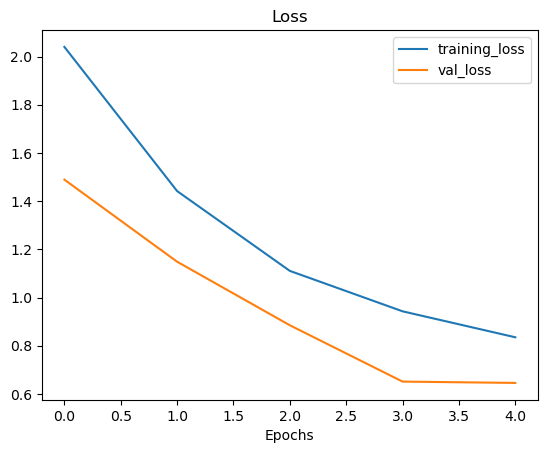

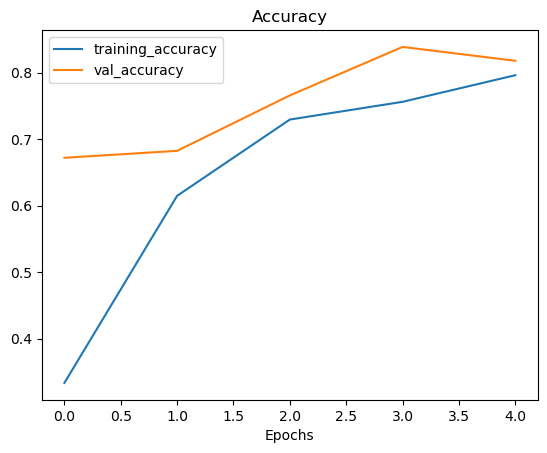

In [91]:
plot_loss_curves(history_10_percent_data)

Според тези резултати, производителността на нашия модел с 10% от данните и аугментация не е толкова добра, колкото на модела с 10% от данните без аугментация (виж резултатите на модел 0 по-горе). Въпреки това, кривите показват положителна тенденция, което означава, че ако продължим обучението за по-дълго време, неговите метрики вероятно ще се подобрят.